# Building networks: Combining pathways (From Section 5.3)
Viewed individually, properties such as ATP yield per glucose can be easily deduced for linear pathways like glycolysis. However, by considering glycolysis and pentose phosphate activity together, we can begin to study more interesting, physiologically relevant metabolic network properties. Here we will use simulation to examine some of the properties resulting from pathway integration.

```{figure} ../images/ppp_map.png
---
height: 500px
name: pentose_phosphate_map
---
The system formed by the pentose phosphate pathway once all its reactions, demands, inputs, and outputs are combined.

```

## A small network can display systems properties
The glycolysis and pentose phosphate models can be combined using the commands shown in the code block below. The pentose phosphate pathway reconstruction contains boundary reactions for the transport of three glycolytic intermediates into or out of the pentose phosphate pathway: glucose 6-phosphate, fructose 6-phosphate, and glyceraldehyde 3-phosphate ({numref}`pentose_phosphate_map`). Since the glycolysis model can fully metabolize these intermediates, their boundary reactions are removed.

In [1]:
import cobra
ppp = cobra.io.load_json_model('../resources/ppp_model.json')
glycolysis = cobra.io.load_json_model('../resources/glycolysis_model.json')

# Add create a new model "combined_model" consisting of two
# pathways merged together
combined = glycolysis.merge(ppp)

# Change name of the model
combined.id = 'glyc_ppp'

# Remove inputs/outputs that are no longer necessary, as these are Glycolysis intermediates
for m in ['g3p_c', 'g6p_c', 'f6p_c']:
    combined.reactions.get_by_id('EX_' + m).remove_from_model()

Ignoring reaction 'EX_co2_c' since it already exists.
Ignoring reaction 'EX_o2_c' since it already exists.
Ignoring reaction 'EX_h_c' since it already exists.
Ignoring reaction 'EX_h2o_c' since it already exists.
Ignoring reaction 'EX_g3p_c' since it already exists.
Ignoring reaction 'EX_g6p_c' since it already exists.
Ignoring reaction 'EX_f6p_c' since it already exists.


Building even this simple networks enables us to study common properties of biochemical reaction networks.  In the remainder of this section we will focus on computationally illustrating 1) trade-offs in the use of a network and 2) pathway redundancy that is reflected in alternative solutions.

## Characterizing trade-offs
With the addition of the pentose phosphate pathway to glycolysis, glucose is offered alternative metabolic fates. This branch point occurs at glucose 6-phosphate where it can either be consumed by G6PDH (and enter the oxidative pentose phosphate pathway) or consumed by PGI (and enter glycolysis as in Chapter 3). Whether glucose 6-phosphate is consumed by PGI or G6PDH has significant energetics implications.

```{figure} ../images/figure_1.png
---
height: 500px
name: ppp_tradeoffs
---
A) Metabolic outputs from glycolysis (Blue) or when upper glycolysis is bypassed by the pentose phosphate pathway (Orange). The glucose input
is at -1. B) and C) The flux states that provide the metabolic outputs in A) are shown
```

The code below computes with the joined pentose phosphate pathway and glycolysis model to generate {numref}`ppp_tradeoffs`). 

```{note}
Use the launch buttons in the top right to regenerate the plot here (using Live Code) or open in a Binder environment to run code and see the solutions on an Escher Map
```

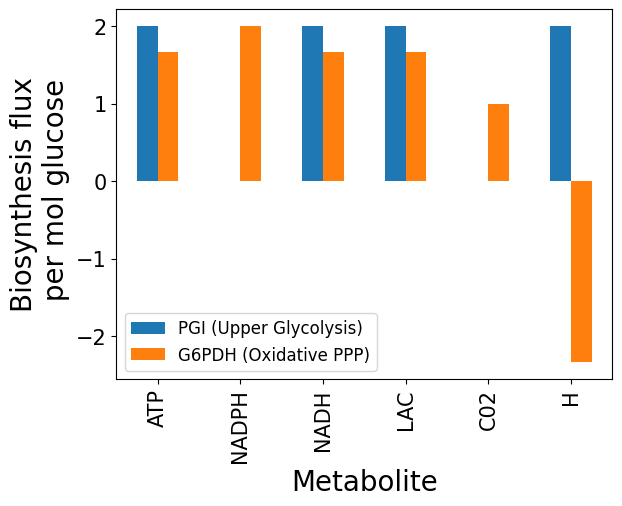

In [30]:
import cobra
import pandas as pd

# Initialize variables 
data = pd.DataFrame()
solution_fluxes = {}

# Load model
combined = cobra.io.load_json_model('../resources/glycolysis_ppp_model.json')
combined.reactions.EX_glc__D_c.lower_bound = -1
combined.reactions.EX_o2s_c.lower_bound = -1000
combined.objective = 'ATPM'

sol2 = combined.optimize()
solution_fluxes['PGI'] = sol2.fluxes

surrogate_reactions = {'ATP': 'ATPM', 'NADPH': 'GTHOr', 'NADH': 'GAPD', 'LAC': 'EX_lac__L_c', 
                       'C02': 'EX_co2_c', 'H': 'EX_h_c'}
quantity_of_interest = list(surrogate_reactions.keys())
surrogates = list(surrogate_reactions.values())
data.loc['PGI (Upper Glycolysis)', quantity_of_interest] = sol2.fluxes[surrogates].values

combined.reactions.PGI.bounds = (0, 0)

sol1=combined.optimize()
solution_fluxes['G6PDH'] = sol1.fluxes
data.loc['G6PDH (Oxidative PPP)', quantity_of_interest] = sol1.fluxes[surrogates].values

ax = data.T.plot(kind='bar')
ax.tick_params(labelsize=15)
ax.set_ylabel('Biosynthesis flux\n per mol glucose', size=20)
ax.set_xlabel('Metabolite', size=20)
ax.legend(fontsize=12)

In [34]:
from ipywidgets import Dropdown, RadioButtons, VBox, Output
from IPython.display import display
from escher import Builder

# ---------------------------------------
# Escher Map: Create an Escher Builder for flux visualization
# ---------------------------------------
builder = Builder(map_json='../resources/gly_ppp_curated_map.json', 
                  reaction_data=solution_fluxes['PGI'])

builder.reaction_scale = [
    {'type': 'value', 'color': 'red', 'size': 20, 'value': -0.01},
    {'type': 'value', 'color': 'grey', 'size': 0, 'value': 0},
    {'type': 'value', 'color': 'red', 'size': 20, 'value': 0.01}
]

escher_out = Output()
with escher_out:
    display(builder)

# ---------------------------------------
# ipywidgets for interactive toggling
# ---------------------------------------
condition_widget = RadioButtons(options=['PGI', 'G6PDH'],
                                value='PGI', description='Route:')

def update_outputs(change):
    # Get current selections
    cond = condition_widget.value

    # --- Update Escher map ---
    flux_data = solution_fluxes[cond]
    builder.reaction_data = flux_data

# Attach the update function to both widgets
condition_widget.observe(update_outputs, names='value')

# ---------------------------------------
# Display all interactive elements in the notebook
# ---------------------------------------
ui = VBox([condition_widget])
display(ui)
escher_out

Output()